In [51]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import jupyter_helper
from keras.backend import clear_session
import pandas as pd
import numpy as np
from LSTM_for_Stock.data_processor import DataLoaderStock
from LSTM_for_Stock.data_processor import DataHelper
from jupyter_helper import wrapper_CCI
from jupyter_helper import normalize_CCI
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


In [38]:
window=3
days=1
dl = DataLoaderStock('000002', wrapper=wrapper_CCI())
df = dl.load()

def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['close']
    X = data.drop(columns=['close']).iloc[:, :]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [39]:
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(df)

In [43]:
regressor = xgb.XGBRegressor(
    gamma=0.0,
    n_estimators=500,
    base_score=0.7,
    colsample_bytree=1,
    learning_rate=0.005)
xgbModel = regressor.fit(
    X_train_FI,
    y_train_FI,
    eval_set=[(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)],
    verbose=False)
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

C:\Users\GuQiang\AppData\Local\conda\conda\envs\finance35\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\GuQiang\AppData\Local\conda\conda\envs\finance35\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


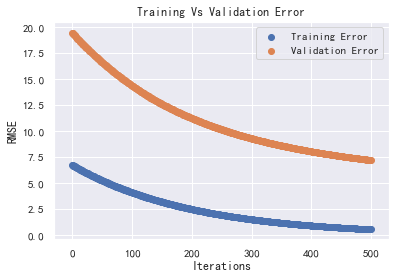

In [44]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

Text(0.5, 1.0, '特征技术指标的重要性')

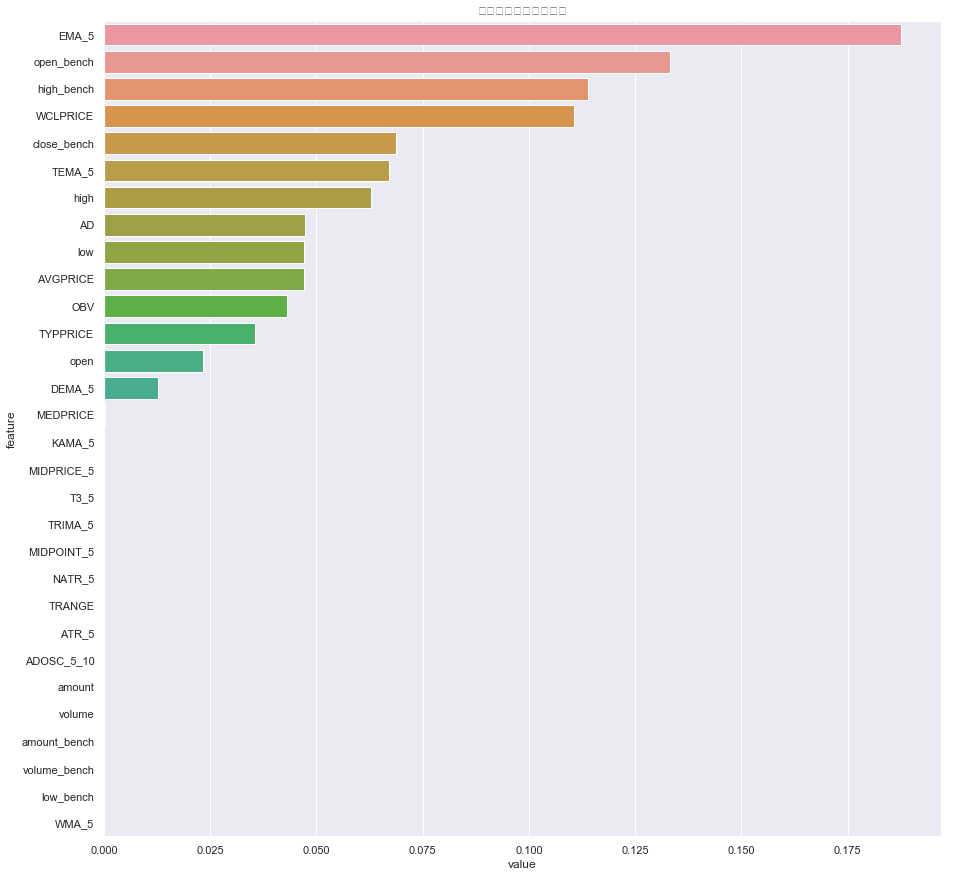

In [91]:
df=pd.DataFrame({'feature':X_test_FI.columns,'value':xgbModel.feature_importances_.tolist()})
df=df.sort_values("value", ascending=False)
g=sns.barplot(data=df,x='value',y='feature')
g.axes.set_title('特征技术指标的重要性')